In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [3]:
bike_data = pd.read_csv('daily-bike-share.csv')
bike_data['day'] = pd.DatetimeIndex(bike_data['dteday']).day
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit', 'day']
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals,day
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,1
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,2
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,3
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,4
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,5


In [4]:
bike_data[numeric_features + ['rentals']].describe()

,temp,atemp,hum,windspeed,rentals
count,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.474354,0.627894,0.190486,848.176471
std,0.183051,0.162961,0.142429,0.077498,686.622488
min,0.059130,0.079070,0.000000,0.022392,2.000000
25%,0.337083,0.337842,0.520000,0.134950,315.500000
50%,0.498333,0.486733,0.626667,0.180975,713.000000
75%,0.655417,0.608602,0.730209,0.233214,1096.000000
max,0.861667,0.840896,0.972500,0.507463,3410.000000


In [6]:
X= bike_data[['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']].values
y = bike_data['rentals'].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 511 rows
Test Set: 220 rows


In [8]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor()

In [75]:
def evaluate(X, y, model):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    print(f"MSE : {mse}\nRMSE : {rmse}\nR2 :{r2}")

In [78]:
def plot_predAct(y, pred):
    plt.scatter(y, pred, c='green')
    plt.xlabel('Actual Labels')
    plt.ylabel('Predicted Labels')
    plt.title('Daily Bike Share Predictions')

    z = np.polyfit(y, pred, 1)
    p = np.poly1d(z)

    plt.plot(y,p(y), color='r')
    plt.show()

MSE : 103951.17331640475
RMSE : 322.41459848524966
R2 :0.7962102490674857


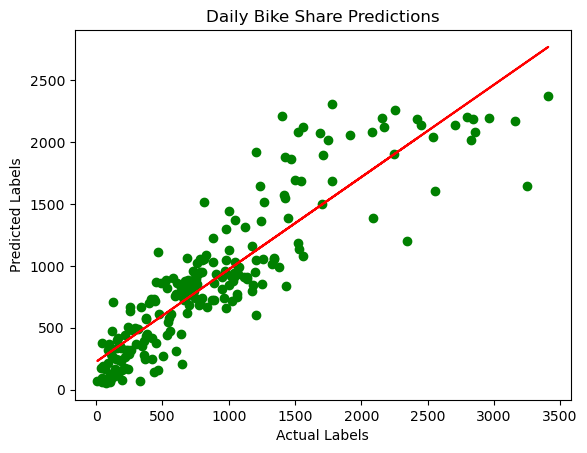

In [82]:
evaluate(X_test, y_test, gbr)
plot_predAct(y_test, predictions)

# Chosing the best hyperparameters

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

In [22]:
# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

#Hyperparameter that we'll try
params = {
    'learning_rate': [0.1, 0.5, 1.0, 0.01],
    'n_estimators' : [50, 100, 150]
}

In [23]:
# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(X_train, y_train)

print("Best parameter combination : ", gridsearch.best_params_)

Best parameter combination :  {'learning_rate': 0.1, 'n_estimators': 100}


In [24]:
#Get the best model
model = gridsearch.best_estimator_
model

GradientBoostingRegressor()

MSE : 100112.17500318184
RMSE : 316.4050805584225
R2 :0.8037363643110409


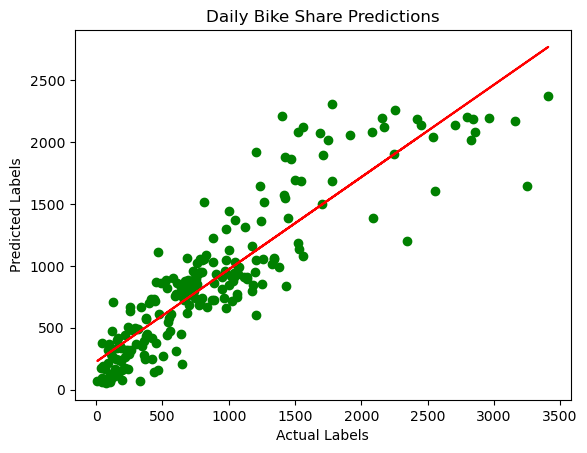

In [83]:
#Evaluate the model and plot
evaluate(X_test, y_test, model)
plot_predAct(y_test, predictions)

# Data preprocessing Pipeline

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression

In [43]:
#Define preprocessing for numeric coçlumns (scale them)
numeric_features = [6,7,8,9]
numeric_transformer = Pipeline(steps =[("Scaler", StandardScaler())])

In [44]:
#Define preprocessing for categorical features (encode them)ù
categorical_features = [0, 1, 2, 3, 4, 5]
categorical_transformer = Pipeline(steps = [("onehot", OneHotEncoder(handle_unknown='ignore'))])

In [45]:
#Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features )
    ])

In [57]:
#Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])

In [61]:
#fit the pipeline to train a linear regression model on the trainning set
model_p = pipeline.fit(X_train, (y_train))
print(model_p)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler())]),
                                                  [6, 7, 8, 9]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('regressor', GradientBoostingRegressor())])


MSE : 105097.57738317177
RMSE : 324.18756512730675
R2 :0.7939627958470842


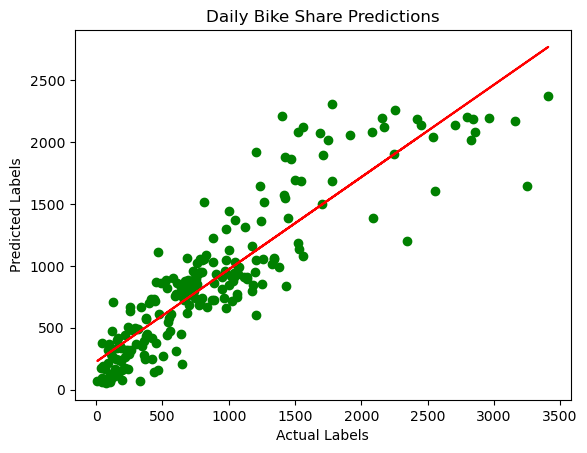

In [85]:
#Evaluate the model
evaluate(X_test, y_test, model_p)
plot_predAct(y_test, predictions)

In [90]:
# Use a different estimator in the pipeline
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])

In [91]:
model_R = pipeline.fit(X_train, (y_train))
print (model_R)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler())]),
                                                  [6, 7, 8, 9]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('regressor', RandomForestRegressor())])


MSE : 105336.1348522727
RMSE : 324.5552878205387
R2 :0.7934951189016475


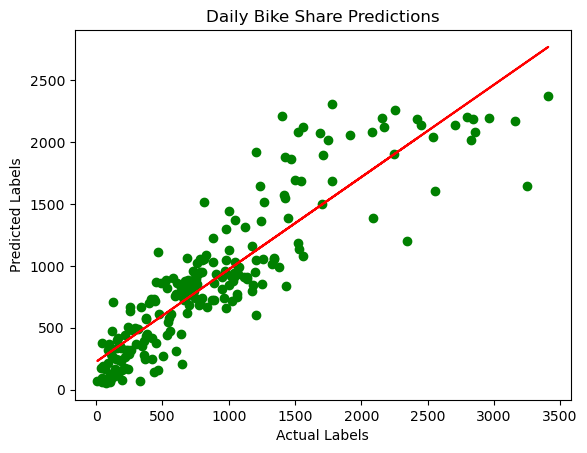

In [88]:
evaluate(X_test, y_test, model_R)
plot_predAct(y_test, predictions)

In [92]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())])

model_LR = pipeline.fit(X_train, (y_train))
print (model_LR)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler())]),
                                                  [6, 7, 8, 9]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('regressor', LinearRegression())])


MSE : 174159.78904544807
RMSE : 417.324560798245
R2 :0.6585706644791662


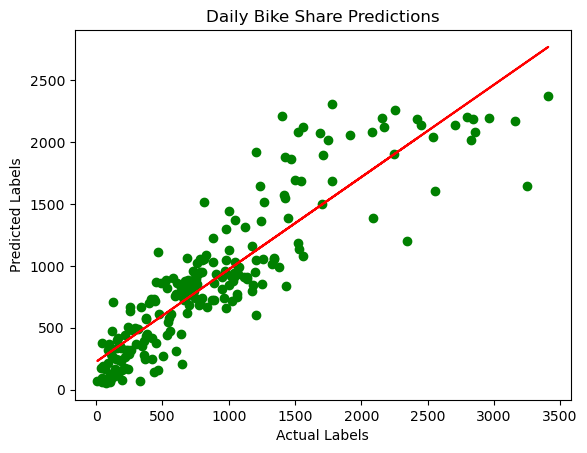

In [93]:
evaluate(X_test, y_test, model_LR)
plot_predAct(y_test, predictions)

# Save the model

In [94]:
import joblib

filename = './bike-share.pkl'
joblib.dump(model, filename)

['./bike-share.pkl']

## Load the model and use it

In [95]:
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array([[1,1,0,3,1,1,0.226957,0.22927,0.436957,0.1869]]).astype('float64')

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Prediction: {:.0f} rentals'.format(np.round(result[0])))

Prediction: 111 rentals


In [97]:
# An array of features based on five-day weather forecast
X_new = np.array([[0,1,1,0,0,1,0.344167,0.363625,0.805833,0.160446],
                  [0,1,0,1,0,1,0.363478,0.353739,0.696087,0.248539],
                  [0,1,0,2,0,1,0.196364,0.189405,0.437273,0.248309],
                  [0,1,0,3,0,1,0.2,0.212122,0.590435,0.160296],
                  [0,1,0,4,0,1,0.226957,0.22927,0.436957,0.1869]])


# Use the model to predict rentals
results = loaded_model.predict(X_new)
results

array([597.06, 757.34, 243.39, 210.03, 283.19])

In [98]:
print('5-day rental predictions:')
for prediction in results:
    print(np.round(prediction))

5-day rental predictions:
597.0
757.0
243.0
210.0
283.0


### KPOVIESSI O. A. Stéphane